<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# GA Capstone: Fake News Classifier

Author: Tan Kai Yong Alvin

# Notebook 3: Sentiment Analysis and Conclusion

## Sentiment Analysis

The creators of fake news use various stylistic tricks to promote the success of their creations, with one of them being to excite the sentiments of the recipients. This has led to sentiment analysis, the part of text analytics in charge of determining the polarity and strength of sentiments expressed in a text, to be used in fake news detection approaches, either as a basis of the system or as a complementary element. 

In this section, sentiment analysis will be applied to evaluate sentiment of the fake news article. The outcome of the sentiment analysis can enable organisation / government bodies to prioritise their efforts to counter the fake news. Fake news which spreads negative sentiments  (i.e. anger, disgust and fear) should be given more attention.

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

### Import

The dataset comprising of 44689 (both fake and real news) will be used for sentiment analysis.

In [2]:
combined_df = pd.read_csv('./datasets/combined_df.csv')

In [3]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            44689 non-null  object 
 1   text             44689 non-null  object 
 2   title_text       44689 non-null  object 
 3   subject          44689 non-null  object 
 4   date             44679 non-null  object 
 5   wordcount_title  44689 non-null  int64  
 6   wordcount_text   44689 non-null  int64  
 7   wordcount_total  44689 non-null  int64  
 8   label            44689 non-null  int64  
 9   year             44679 non-null  float64
dtypes: float64(1), int64(4), object(5)
memory usage: 3.4+ MB


In [4]:
combined_df.head()

,title,text,title_text,subject,date,wordcount_title,wordcount_text,wordcount_total,label,year
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a ...","As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Represe...",politicsNews,2017-12-31,10,749,759,0,2017.0
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administra...","U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in ...",politicsNews,2017-12-29,9,624,633,0,2017.0
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, sai...","Senior U.S. Republican senator: 'Let Mr. Mueller do his job' WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who se...",politicsNews,2017-12-31,10,457,467,0,2017.0
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence in...","FBI Russia probe helped by Australian diplomat tip-off: NYT WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor...",politicsNews,2017-12-30,9,376,385,0,2017.0
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight wi

### Data Pre-processing

In [6]:
# lower case the text
combined_df['lower_case'] = combined_df['title_text'].str.lower()

In [7]:
# remove website addresses from selftext_title column
# instantiate regex to identify and remove urls
combined_df['drop_url'] = combined_df['lower_case'].apply(lambda text: re.sub(r"http\S+", '', text))

In [8]:
# remove punctuations
combined_df['drop_punctuations'] = combined_df['drop_url'].apply(lambda text: re.sub(r'[^\w\s]', '', text))

In [9]:
combined_df['title_text_sentiment_analysis'] = combined_df['drop_punctuations']

In [10]:
combined_df['title_text_sentiment_analysis']

0        as us budget fight looms republicans flip their fiscal script washington reuters  the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on sunday and urged budget restraint in 2018 in keeping with a sharp pivot under way among republicans us representative mark mea...
1        us military to accept transgender recruits on monday pentagon washington reuters  transgender people will be allowed for the first time to enlist in the us military starting on monday as ordered by federal courts the pentagon said on friday after president donald trumps administration decided not to appeal rulings that blocked his transgender ban two federal appeals courts one in washington an...
2        senior us republican senator let mr mueller do his job washington reuters  the special counsel investigation of links between russia and president trumps 2016 election campa

In [11]:
# create dataframe for sentiment analysis
sentiment_analysis_df = combined_df[['title_text','title_text_sentiment_analysis', 'label']]
sentiment_analysis_df.head()

,title_text,title_text_sentiment_analysis,label
0,"As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Represe...",as us budget fight looms republicans flip their fiscal script washington reuters the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on sunday and urged budget restraint in 2018 in keeping with a sharp pivot under way among republicans us representative mark mea...,0
1,"U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in ...",us military to accept transgender recruits on monday pentagon washington reuters transgender people will be allowed for the first time to enlist in the us military starting on monday as ordered by federal courts the pentagon said on friday after president donald trumps administration decided not to appeal rulings that blocked his transgender ban two federal appeals courts one in washington an...,0
2,"Senior U.S. Republican senator: 'Let Mr. Mueller do his job' WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who se...",senior us republican senator let mr mueller do his job washington reuters the special counsel investigation of links between russia and president trumps 2016 election campaign should continue without interference in 2018 despite calls from some trump administration allies and republican lawmakers to shut it down a prominent republican senator said on sunday lindsey graham who serves on the se...,0
3,"FBI Russia probe helped by Australian diplomat tip-off: NYT WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor...",fbi russia probe helped by australian diplomat tipoff nyt washington reuters trump campaign adviser george papadopoulos told an australian diplomat in may 2016 that russia had political dirt on democratic presidential candidate hillary clinton the new york times reported on saturday the conversation between papadopoulos and the diplomat alexander downer in london was a driving factor behind t...,0
4,"Trump wants Postal Service to charge 'much more' for Amazon shipments SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past. “Why is the United States Post Office, which is losing many billions of dollars a y...",trump wants postal service to charge much more for amazon shipments seattlewashington reuters president donald trump called on the us postal service on friday to charge much more to ship packages for amazon amzno picking another fight with an online retail giant he has criticized in the past why is the united states post office wh

#### Real News

In [12]:
# filter for fake news
real_news_df = sentiment_analysis_df[(sentiment_analysis_df['label'] == 0)]

In [13]:
real_test = real_news_df[['title_text_sentiment_analysis']]
real_test

,title_text_sentiment_analysis
0,as us budget fight looms republicans flip their fiscal script washington reuters the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on sunday and urged budget restraint in 2018 in keeping with a sharp pivot under way among republicans us representative mark mea...
1,us military to accept transgender recruits on monday pentagon washington reuters transgender people will be allowed for the first time to enlist in the us military starting on monday as ordered by federal courts the pentagon said on friday after president donald trumps administration decided not to appeal rulings that blocked his transgender ban two federal appeals courts one in washington an...
2,senior us republican senator let mr mueller do his job washington reuters the special counsel investigation of links between russia and president trumps 2016 election campaign should continue without interference in 2018 despite calls from some trump administration allies and republican lawmakers to shut it down a prominent republican senator said on sunday lindsey graham who serves on the se...
3,fbi russia probe helped by australian diplomat tipoff nyt washington reuters trump campaign adviser george papadopoulos told an australian diplomat in may 2016 that russia had political dirt on democratic presidential candidate hillary clinton the new york times reported on saturday the conversation between papadopoulos and the diplomat alexander downer in london was a driving factor behind t...
4,trump wants postal service to charge much more for amazon shipments seattlewashington reuters president donald trump called on the us postal service on friday to charge much more to ship packages for amazon amzno picking another fight with an online retail giant he has criticized in the past why is the united states post office which is losing many billions of dollars a year while chargin...
...,...
21206,fully committed nato backs new us approach on afghanistan brussels reuters nato allies on tuesday welcomed president donald trump s decision to commit more forces to afghanistan as part of a new us strategy he said would require more troops and funding from america s partners having run for the white house last year on a pledge to withdraw swiftly from afghanistan trump reversed course on mon...
21207,lexisnexis withdrew two products from chinese market london reuters lexisnexis a provider of legal regulatory and business information said on tuesday it had withdrawn two products from the chinese market in march this year after it was asked to remove some content the issue of academic freedom in china hit the headlines this week after the leading british academic publisher cambridge unive...
21208,minsk cultural hub becomes haven from authorities minsk reuters in the shadow of disused sovietera factories in minsk a street lined with eclectic bars art galleries and yoga studios has become a haven from the vigilant eyes of the belarussian authorities this place is like an island said yegor 21 who works at popular bar hooligan it s the street of freedom the government of president al...
21209,vatican upbeat on possibility of pope francis visiting russia moscow reuters vatican secretary of state cardinal pietro parolin said on tuesday that there was positive momentum behind the idea of pope francis visiting russia but suggested there was more work to be done if it were to happen parolin speaking at a joint news conference in moscow alongside russian foreign minister sergei lavro...


#### Fake News

In [14]:
# filter for fake news
fake_news_df = sentiment_analysis_df[(sentiment_analysis_df['label'] == 1)]

In [15]:
fake_test = fake_news_df[['title_text_sentiment_analysis']]
fake_test

,title_text_sentiment_analysis
21211,donald trump sends out embarrassing new years eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and the very dishonest fake news media the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wi...
21212,drunk bragging trump staffer started russian collusion investigation house intelligence committee chairman devin nunes is going to have a bad day he s been under the assumption like many of us that the christopher steeledossier was what prompted the russia investigation so he s been lashing out at the department of justice and the fbi in order to protect trump as it happens the dossier is not...
21213,sheriff david clarke becomes an internet joke for threatening to poke people in the eye on friday it was revealed that former milwaukee sheriff david clarke who was being considered for homeland security secretary in donald trump s administration has an email scandal of his ownin january there was a brief runin on a plane between clarke and fellow passenger dan black who he later had detained...
21214,trump is so obsessed he even has obamas name coded into his website images on christmas day donald trump announced that he would be back to work the following day but he is golfing for the fourth day in a row the former reality show star blasted former president barack obama for playing golf and now trump is on track to outpace the number of golf games his predecessor playedupdated my track...
21215,pope francis just called out donald trump during his christmas speech pope francis used his annual christmas day message to rebuke donald trump without even mentioning his name the pope delivered his message just days after members of the united nations condemned trump s move to recognize jerusalem as the capital of israel the pontiff prayed on monday for the peaceful coexistence of two stat...
...,...
44684,mcpain john mccain furious that iran treated us sailors well 21st century wire says as 21wire reported earlier this week the unlikely mishap of two us naval vessels straying into iranian waters just hours before the president s state of the union speech followed by the usual parade of archneocons coming on tv in real time to declare the incident as an act of aggression by iran against th...
44685,justice yahoo settles email privacy classaction 4m for lawyers 0 for users 21st century wire says it s a familiar theme whenever there is a dispute or a change of law and two tribes go to war there is normally only one real winner after the tribulation the lawyers ars technicain late 2013 yahoo was hit with six lawsuits over its practice of using automated scans of email to produce targeted a...
44686,sunnistan us and allied safe zone plan to take territorial booty in northern syria patrick henningsen 21st century wireremember when the obama administration told the world how it hoped to identify 5000 reliable nonjihadist moderate rebels hanging out in turkey and jordan who might want to fight for washington in syria after all the drama over its infamous train and equip program to creat...
44687,how to blow 700 million al jazeera america finally calls it quits 21st century wire says al jazeera america will go down in history as one of the biggest failures in broadcast media historyever since the us and its allies began plotting to overthrow libya and syria al jazeera has deteriorated from a promising international news network in 2003 into what it has become in 2016 a fullblown ag...


In [16]:
#fake_test['id'] = fake_test.index

In [17]:
#fake_test

### Modeling

"j-hartmann/emotion-english-distilroberta-base" model from huggingface will be used for sentiment analysis [Source](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base?text=Oh+wow.+I+didn%27t+know+that.)

The "j-hartmann/emotion-english-distilroberta-base" model is trained ousing 6 datasets consisting of 2,811 observations per class of emotion with a total of 20,000 observations in total). The model is able to classify emotions (in English data) into 6 basic emotions (i.e. anger, disgust, fear, joy, neutral, sadness and surprise') and a neutral class. 

In [18]:
# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [19]:
# load tokenizer and model, create trainer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

#### Fake news

In [20]:
text_column = "title_text_sentiment_analysis"
pred_texts = fake_test[text_column].astype('str').tolist()

In [21]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [22]:
# Run predictions
predictions = trainer.predict(pred_dataset)

***** Running Prediction *****
  Num examples = 23478
  Batch size = 8


In [23]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [24]:
# scores raw
temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

In [25]:
# work in progress
# container
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []

# extract scores (as many entries as exist in pred_texts)
for i in range(len(pred_texts)):
  anger.append(temp[i][0])
  disgust.append(temp[i][1])
  fear.append(temp[i][2])
  joy.append(temp[i][3])
  neutral.append(temp[i][4])
  sadness.append(temp[i][5])
  surprise.append(temp[i][6])

In [26]:
# Create DataFrame with texts, predictions, labels, and scores
fake_pred_df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores,  anger, disgust, fear, joy, neutral, sadness, surprise)), columns=['text','pred','label','score', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])
fake_pred_df.head()

,text,pred,label,score,anger,disgust,fear,joy,neutral,sadness,surprise
0,donald trump sends out embarrassing new years eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to his enemies haters and the very dishonest fake news media the former reality show star had just one job to do and he couldn t do it as our country rapidly grows stronger and smarter i want to wi...,6,surprise,0.243963,0.105959,0.000809,0.202171,0.165929,0.043285,0.237884,0.243963
1,drunk bragging trump staffer started russian collusion investigation house intelligence committee chairman devin nunes is going to have a bad day he s been under the assumption like many of us that the christopher steeledossier was what prompted the russia investigation so he s been lashing out at the department of justice and the fbi in order to protect trump as it happens the dossier is not...,0,anger,0.826385,0.826385,0.002015,0.031360,0.014475,0.023319,0.080639,0.021807
2,sheriff david clarke becomes an internet joke for threatening to poke people in the eye on friday it was revealed that former milwaukee sheriff david clarke who was being considered for homeland security secretary in donald trump s administration has an email scandal of his ownin january there was a brief runin on a plane between clarke and fellow passenger dan black who he later had detained...,2,fear,0.731606,0.178134,0.000379,0.731606,0.022893,0.011038,0.032793,0.023157
3,trump is so obsessed he even has obamas name coded into his website images on christmas day donald trump announced that he would be back to work the following day but he is golfing for the fourth day in a row the former reality show star blasted former president barack obama for playing golf and now trump is on track to outpace the number of golf games his predecessor playedupdated my track...,6,surprise,0.877671,0.007678,0.001895,0.016154,0.017540,0.068035,0.011026,0.877671
4,pope francis just called out donald trump during his christmas speech pope francis used his annual christmas day message to rebuke donald trump without even mentioning his name the pope delivered his message just days after members of the united nations condemned trump s move to recognize jerusalem as the capital of israel the pontiff prayed on monday for the peaceful coexistence of two stat...,5,sadness,0.773183,0.085616,0.000910,0.027602,0.092834,0.013954,0.773183,0.005902


In [27]:
fake_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23478 entries, 0 to 23477
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      23478 non-null  object 
 1   pred      23478 non-null  int64  
 2   label     23478 non-null  object 
 3   score     23478 non-null  float32
 4   anger     23478 non-null  float32
 5   disgust   23478 non-null  float32
 6   fear      23478 non-null  float32
 7   joy       23478 non-null  float32
 8   neutral   23478 non-null  float32
 9   sadness   23478 non-null  float32
 10  surprise  23478 non-null  float32
dtypes: float32(8), int64(1), object(2)
memory usage: 1.3+ MB


In [28]:
# distribution of emotions
fake_pred_df['label'].value_counts(normalize =True)

anger       0.301133
fear        0.289590
surprise    0.156359
sadness     0.125650
joy         0.097666
neutral     0.022702
disgust     0.006900
Name: label, dtype: float64

<module 'matplotlib.pyplot' from 'C:\\Users\\alvintky89\\AppData\\Roaming\\Python\\Python38\\site-packages\\matplotlib\\pyplot.py'>

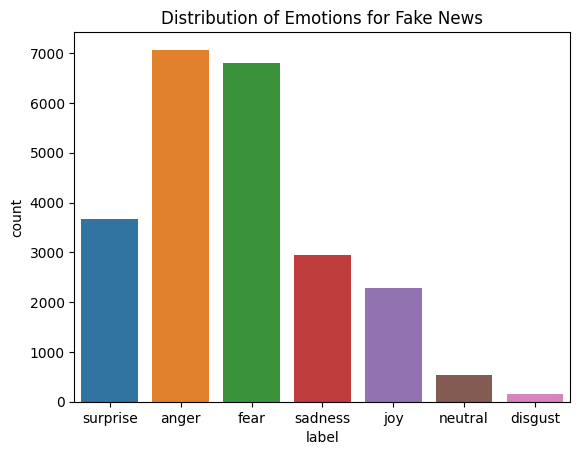

In [29]:
# count plot on single categorical variable
sns.countplot(x ='label', data = fake_pred_df)
 
# Show the plot
plt.title('Distribution of Emotions for Fake News')
plt

In [30]:
pd.options.display.max_colwidth = 800
fear_df = fake_pred_df.loc[fake_pred_df['label'] == 'fear'] 
fear_df.head(20)

,text,pred,label,score,anger,disgust,fear,joy,neutral,sadness,surprise
2,sheriff david clarke becomes an internet joke for threatening to poke people in the eye on friday it was revealed that former milwaukee sheriff david clarke who was being considered for homeland security secretary in donald trump s administration has an email scandal of his ownin january there was a brief runin on a plane between clarke and fellow passenger dan black who he later had detained by the police for no reason whatsoever except that maybe his feelings were hurt clarke messaged the police to stop black after he deplaned and now a search warrant has been executed by the fbi to see the exchangesclarke is calling it fake news even though copies of the search warrant are on the internet i am unintimidated by lib media attempts to smear and discredit me with their fake news report...,2,fear,0.731606,0.178134,0.000379,0.731606,0.022893,0.011038,0.032793,0.023157
8,former cia director slams trump over un bullying openly suggests hes acting like a dictator tweet many people have raised the alarm regarding the fact that donald trump is dangerously close to becoming an autocrat the thing is democracies become autocracies right under the people s noses because they can often look like democracies in the beginning phases this was explained by republican david frum just a couple of months into donald trump s presidency in a piece in the atlantic called how to build an autocracy in fact if you really look critically at what is happening right now the systematic discrediting of vital institutions such as the free press and the federal bureau of investigation as well the direct weaponization of the department of justice in order to go after trump s fo...,2,fear,0.970354,0.014795,0.000263,0.970354,0.003881,0.003366,0.002785,0.004556
9,watch brandnew protrump ad features so much a kissing it will make you sick just when you might have thought we d get a break from watching people kiss donald trump s ass and stroke his ego ad nauseam a protrump group creates an ad that s nothing but people doing even more of those exact things america first policies is set to release this ad called thank you president trump on christmas day and well we threw up a little in our mouths trying to watch thisbasically the spot is nothing but people fawning all over trump for all the stuff he hasn t actually done the ad includes a scene with a little girl thanking trump for bringing back merry christmas which never went away there are even videos of president obama saying merry christmas himself a man thanks him for cutting his taxes...,2,fear,0.471639,0.111552,0.152647,0.471639,0.058587,0.025901,0.041144,0.138530
13,watch lindsey graham trashes media for portraying trump as kooky forgets his own words the media has been talking all day about trump and the republican party s scam of a tax bill as well as the sheer obsequiousness of trump s cabinet and then members of congress after their tax scam was all but passed but the media isn t quite saying what trump wants they ve been doing analysis and discussion all day long rather than praising it for the grand achievement trump believes it is the gop has increasingly sounded exactly like trump when it comes to media coverage and coverage of the tax scam is no different coverage of trump in general hasn t changedtoday lindsey graham went after the media for portraying trump as a kook and unfit for office they wouldn t be doing their job if they weren...,2,fear,0.383953,0.196014,0.001822,0.383953,0.016514,0.099676,0.114901,0.187120
16,the internet brutally mocks disneys new trump robot at hall of presidents a new animatronic figure in the hall of presidents at walt disney world was added where every former leader of the republic is depicted in an audioanimatronics show the figure which supposedly resembles jon voight donald trump was added to the collection and it s absolutely horrifying the internet noticed that toohere s a few more pictures 

In [31]:
fear_df['text'].head(20)

2      sheriff david clarke becomes an internet joke for threatening to poke people in the eye on friday it was revealed that former milwaukee sheriff david clarke who was being considered for homeland security secretary in donald trump s administration has an email scandal of his ownin january there was a brief runin on a plane between clarke and fellow passenger dan black who he later had detained by the police for no reason whatsoever except that maybe his feelings were hurt clarke messaged the police to stop black after he deplaned and now a search warrant has been executed by the fbi to see the exchangesclarke is calling it fake news even though copies of the search warrant are on the internet i am unintimidated by lib media attempts to smear and discredit me with their fake news report...
8      former cia director slams trump over un bullying openly suggests hes acting like a dictator tweet many people have raised the alarm regarding the fact that donald trump is dangerously clo

In [33]:
pd.options.display.max_colwidth = 800
anger_df = fake_pred_df.loc[fake_pred_df['label'] == 'anger'] 
anger_df.head(20)

,text,pred,label,score,anger,disgust,fear,joy,neutral,sadness,surprise
1,drunk bragging trump staffer started russian collusion investigation house intelligence committee chairman devin nunes is going to have a bad day he s been under the assumption like many of us that the christopher steeledossier was what prompted the russia investigation so he s been lashing out at the department of justice and the fbi in order to protect trump as it happens the dossier is not what started the investigation according to documents obtained by the new york timesformer trump campaign adviser george papadopoulos was drunk in a wine bar when he revealed knowledge of russian opposition research on hillary clintonon top of that papadopoulos wasn t just a covfefe boy for trump as his administration has alleged he had a much larger role but none so damning as being a drunken fo...,0,anger,0.826385,0.826385,0.002015,0.031360,0.014475,0.023319,0.080639,0.021807
5,racist alabama cops brutalize black boy while he is in handcuffs graphic images the number of cases of cops brutalizing and killing people of color seems to see no end now we have another case that needs to be shared far and wide an alabama woman by the name of angela williams shared a graphic photo of her son lying in a hospital bed with a beaten and fractured face on facebook it needs to be shared far and wide because this is unacceptableit is unclear why williams son was in police custody or what sort of altercation resulted in his arrest but when you see the photo you will realize that these details matter not cops are not supposed to beat and brutalize those in their custody in the post you are about to see ms williams expresses her hope that the cops had their body cameras on w...,0,anger,0.895715,0.895715,0.023652,0.033232,0.002620,0.007016,0.031918,0.005847
6,fresh off the golf course trump lashes out at fbi deputy director and james comey donald trump spent a good portion of his day at his golf club marking the 84th day he s done so since taking the oath of office it must have been a bad game because just after that trump lashed out at fbi deputy director andrew mccabe on twitter following a report saying mccabe plans to retire in a few months the report follows mccabe s testimony in front of congressional committees this week as well as mounting criticism from republicans regarding the russia probeso naturally trump attacked mccabe with a lie how can fbi deputy director andrew mccabe the man in charge along with leakin james comey of the phony hillary clinton investigation including her 33000 illegally deleted emails be given 700000 for...,0,anger,0.936694,0.936694,0.000569,0.008678,0.004077,0.006482,0.025483,0.018018
7,trump said some insanely racist stuff inside the oval office and witnesses back it up in the wake of yet another court decision that derailed donald trump s plan to bar muslims from entering the united states the new york times published a report on saturday morning detailing the president s frustration at not getting his way and how far back that frustration goesaccording to the article back in june trump stomped into the oval office furious about the state of the travel ban which he thought would be implemented and fully in place by then instead he fumed visas had already been issued to immigrants at such a rate that his friends were calling to say he looked like a fool after making his broad pronouncementsit was then that trump began reading from a document that a top advisor n...,0,anger,0.885495,0.885495,0.000666,0.018867,0.005521,0.002980,0.028718,0.057754
10,papa johns founder retires figures out racism is bad for business a centerpiece of donald trump s campaign and now his presidency has been his white supremacist ways that is why so many of the public feuds he gets into involve people of color one of his favorite targets is of course the players in the national football league who dare to exercise their first amendment rights by kneeling during the nationa

In [34]:
anger_df['text'].head(20)

1      drunk bragging trump staffer started russian collusion investigation house intelligence committee chairman devin nunes is going to have a bad day he s been under the assumption like many of us that the christopher steeledossier was what prompted the russia investigation so he s been lashing out at the department of justice and the fbi in order to protect trump as it happens the dossier is not what started the investigation according to documents obtained by the new york timesformer trump campaign adviser george papadopoulos was drunk in a wine bar when he revealed knowledge of russian opposition research on hillary clintonon top of that papadopoulos wasn t just a covfefe boy for trump as his administration has alleged he had a much larger role but none so damning as being a drunken fo...
5      racist alabama cops brutalize black boy while he is in handcuffs graphic images the number of cases of cops brutalizing and killing people of color seems to see no end now we have another

#### Real news

In [35]:
text_column = "title_text_sentiment_analysis"
real_pred_texts = real_test[text_column].astype('str').tolist()

In [36]:
# Tokenize texts and create prediction data set
real_tokenized_texts = tokenizer(real_pred_texts,truncation=True,padding=True)
real_pred_dataset = SimpleDataset(real_tokenized_texts)

In [37]:
# Run predictions
real_predictions = trainer.predict(real_pred_dataset)

***** Running Prediction *****
  Num examples = 21211
  Batch size = 8


In [38]:
# Transform predictions to labels
real_preds = real_predictions.predictions.argmax(-1)
real_labels = pd.Series(real_preds).map(model.config.id2label)
real_scores = (np.exp(real_predictions[0])/np.exp(real_predictions[0]).sum(-1,keepdims=True)).max(1)

In [39]:
# scores raw
real_temp = (np.exp(real_predictions[0])/np.exp(real_predictions[0]).sum(-1,keepdims=True))

In [40]:
# work in progress
# container
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []

# extract scores (as many entries as exist in pred_texts)
for i in range(len(real_pred_texts)):
  anger.append(real_temp[i][0])
  disgust.append(real_temp[i][1])
  fear.append(real_temp[i][2])
  joy.append(real_temp[i][3])
  neutral.append(real_temp[i][4])
  sadness.append(real_temp[i][5])
  surprise.append(real_temp[i][6])

In [41]:
# Create DataFrame with texts, predictions, labels, and scores
real_pred_df = pd.DataFrame(list(zip(real_pred_texts,real_preds,real_labels,real_scores,  anger, disgust, fear, joy, neutral, sadness, surprise)), columns=['text','pred','label','score', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])
real_pred_df

,text,pred,label,score,anger,disgust,fear,joy,neutral,sadness,surprise
0,as us budget fight looms republicans flip their fiscal script washington reuters the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on sunday and urged budget restraint in 2018 in keeping with a sharp pivot under way among republicans us representative mark meadows speaking on cbs face the nation drew a hard line on federal spending which lawmakers are bracing to do battle over in january when they return from the holidays on wednesday lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues such as immigration policy even as the november congressional election campaigns approach in which republicans will seek ...,4,neutral,0.295244,0.140392,0.002350,0.244271,0.195517,0.295244,0.076498,0.045727
1,us military to accept transgender recruits on monday pentagon washington reuters transgender people will be allowed for the first time to enlist in the us military starting on monday as ordered by federal courts the pentagon said on friday after president donald trumps administration decided not to appeal rulings that blocked his transgender ban two federal appeals courts one in washington and one in virginia last week rejected the administrations request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on jan 1 a justice department official said the administration will not challenge those rulings the department of defense has announced that it will be releasing an independent study of these issues in the coming weeks so rather...,3,joy,0.652748,0.051659,0.000957,0.022619,0.652748,0.143645,0.086386,0.041986
2,senior us republican senator let mr mueller do his job washington reuters the special counsel investigation of links between russia and president trumps 2016 election campaign should continue without interference in 2018 despite calls from some trump administration allies and republican lawmakers to shut it down a prominent republican senator said on sunday lindsey graham who serves on the senate armed forces and judiciary committees said department of justice special counsel robert mueller needs to carry on with his russia investigation without political interference this investigation will go forward it will be an investigation conducted without political influence graham said on cbss face the nation news program and we all need to let mr mueller do his job i think hes the right guy...,5,sadness,0.402499,0.216210,0.001870,0.025324,0.127076,0.164805,0.402499,0.062215
3,fbi russia probe helped by australian diplomat tipoff nyt washington reuters trump campaign adviser george papadopoulos told an australian diplomat in may 2016 that russia had political dirt on democratic presidential candidate hillary clinton the new york times reported on saturday the conversation between papadopoulos and the diplomat alexander downer in london was a driving factor behind the fbis decision to open a counterintelligence investigation of moscows contacts with the trump campaign the times reported two months after the meeting australian officials passed the information that came from papadopoulos to their american counterparts when leaked democratic emails began appearing online according to the newspaper which cited four current and former us and foreign officials bes...,2,fear,0.451436,0.269862,0.004831,0.451436,0.097226,0.104943,0.043497,0.028206
4,trump wants postal service to charge much more for amazon shipments seattlewashington reuters president donald trump called on the us postal service on friday to charge much more to ship packages for amazon amzno picking another fight with an online retail giant he has criticized in the past why is the united states post office which is losing many billions of dollars a year while charging amazon an

In [42]:
real_pred_df['label'].value_counts(normalize =True)

fear        0.492810
anger       0.251002
joy         0.135543
sadness     0.090425
surprise    0.016784
neutral     0.013248
disgust     0.000189
Name: label, dtype: float64

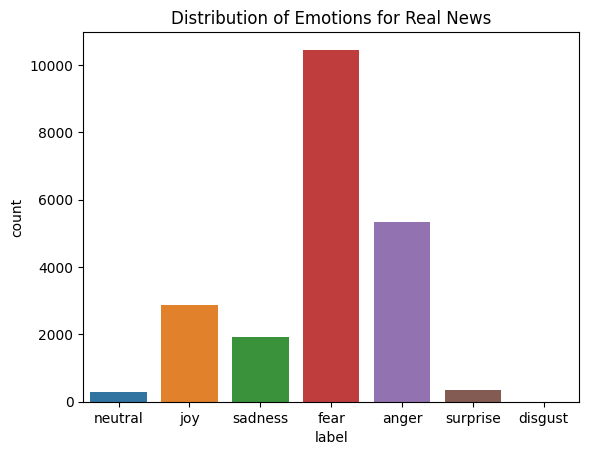

In [43]:
# count plot on single categorical variable
sns.countplot(x ='label', data = real_pred_df)
 
# Show the plot
plt.title('Distribution of Emotions for Real News')
plt.show()

### Sentiment analysis of Fake News

- 'Anger','Fear' and 'Surprise' are the top emotions derived from sentiment analysis of the fake news articles. 'Anger' and 'Fear' are the sentiments of concern as these are sentiments that relates to negative emotions. Only a small number of fake news shows positive emotions (e.g. joy).

- On closer scrutiny, most of the  Fake news features articles features content which:

1. Defamation of the character of a public figure (e.g. Donald Trump) that manipulates political elections and causing political divide.

2. Racism (white supremacy) and sexism related, which divides the socirty  

- While the sentiment analysis also show  a large proportion of real news having 'fear' and 'anger' emotions, it is less of a concern as fake news are far more viral than real news online. Unlike real news, fake news will result in unstable societies and buffeted democracy. Hence, it is important to focus the attention of sentiment analysis on the fake news

In [74]:
# preprocessing of data
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # split our data and run hyperparameter search

In [75]:
stopwords_list = stopwords.words("english")

# some words provided the source of the article, which may reveal explicitly if the news is fake or real.Such words will be omitted to make the model less bias towards source
add_stopwords = ["21wire", "twitter", "reuters", '21WIRE', '21st', 'Century',  'Wire', 'somodevilla', 'getty', 'images', 'subscribe', 'member', 'realdonaldtrump']
stopwords_list.extend(add_stopwords)

In [76]:
# Instantiate a CountVectorizer, excluding stopwords
cvec = CountVectorizer(stop_words=stopwords_list, min_df = 0.01)

In [77]:
X_fear = fear_df['text']
X_fear_cvec = cvec.fit_transform(X_fear)

C:\Users\alvintky89\.conda\envs\dsi-sg-capstone\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['century', 'wire'] not in stop_words.
  warnings.warn(


In [78]:
X_fear_df = pd.DataFrame(X_fear_cvec.toarray(), columns=cvec.get_feature_names())

C:\Users\alvintky89\.conda\envs\dsi-sg-capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


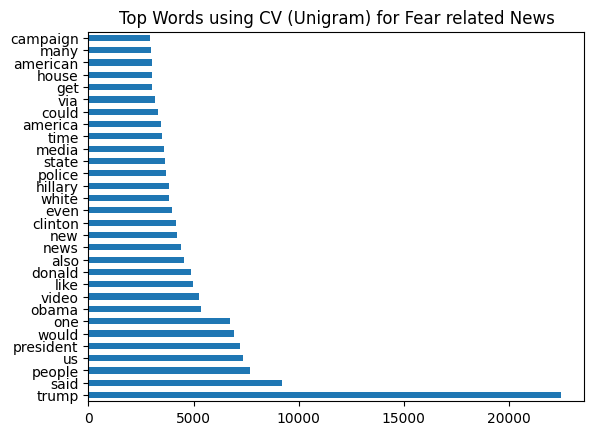

In [79]:
# plot top occuring words in a horizontal bar chart
X_fear_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words using CV (Unigram) for Fear related News', fontsize=12);

In [80]:
# bigrams

In [81]:
cvec_bigram = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords_list, min_df =0.01)

In [82]:
X_fear = fear_df['text']
X_fear_cvec_bi = cvec_bigram.fit_transform(X_fear)

C:\Users\alvintky89\.conda\envs\dsi-sg-capstone\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['century', 'wire'] not in stop_words.
  warnings.warn(


In [83]:
X_fear_bi_df = pd.DataFrame(X_fear_cvec_bi.toarray(), columns=cvec_bigram.get_feature_names())

C:\Users\alvintky89\.conda\envs\dsi-sg-capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


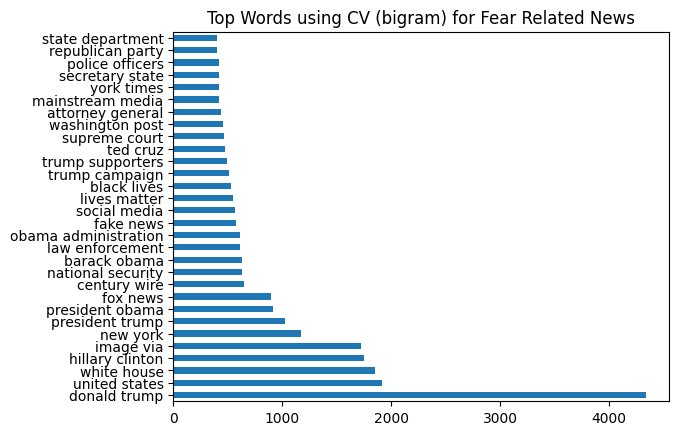

In [84]:
# plot top occuring words in a horizontal bar chart
X_fear_bi_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words using CV (bigram) for Fear Related News', fontsize=12);

In [85]:
cvec_trigram = CountVectorizer(ngram_range=(3, 3), stop_words=stopwords_list, min_df =0.01)

In [86]:
X_fear = fear_df['text']
X_fear_cvec_tri = cvec_trigram.fit_transform(X_fear)

C:\Users\alvintky89\.conda\envs\dsi-sg-capstone\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['century', 'wire'] not in stop_words.
  warnings.warn(


In [87]:
X_fear_df = pd.DataFrame(X_fear_cvec_tri.toarray(), columns=cvec_trigram.get_feature_names())

C:\Users\alvintky89\.conda\envs\dsi-sg-capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


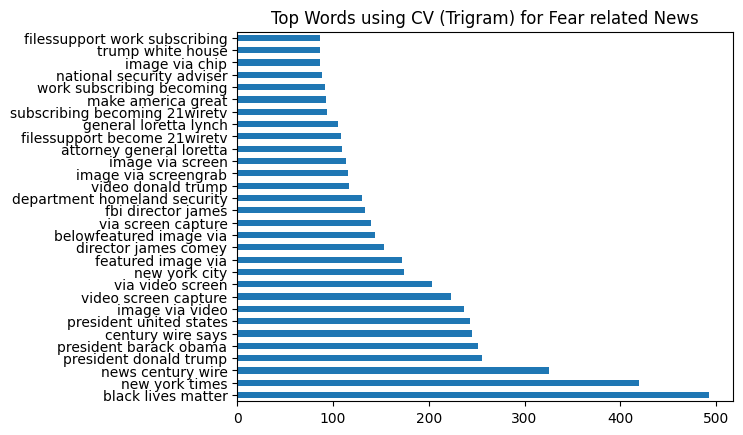

In [88]:
# plot top occuring words in a horizontal bar chart
X_fear_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words using CV (Trigram) for Fear related News', fontsize=12);

In [89]:
X_anger = anger_df['text']
X_anger_cvec = cvec.fit_transform(X_anger)

In [90]:
X_anger_df = pd.DataFrame(X_anger_cvec.toarray(), columns=cvec.get_feature_names())

C:\Users\alvintky89\.conda\envs\dsi-sg-capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


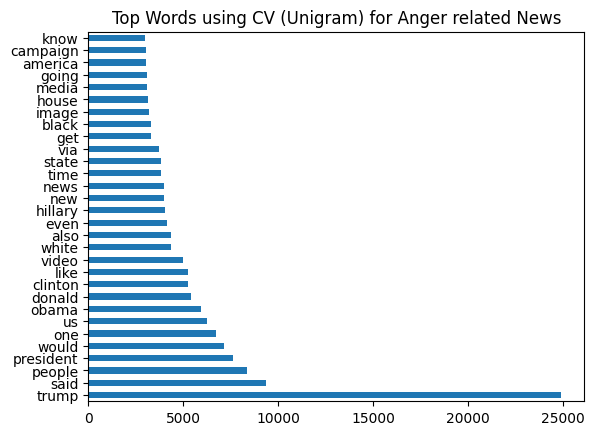

In [91]:
# plot top occuring words in a horizontal bar chart
X_anger_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words using CV (Unigram) for Anger related News', fontsize=12);

In [92]:
# bigrams

In [93]:
cvec_bigram = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords_list, min_df =0.01)

In [94]:
X_anger = anger_df['text']
X_anger_cvec_bi = cvec_bigram.fit_transform(X_anger)

C:\Users\alvintky89\.conda\envs\dsi-sg-capstone\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['century', 'wire'] not in stop_words.
  warnings.warn(


In [95]:
X_anger_bi_df = pd.DataFrame(X_anger_cvec_bi.toarray(), columns=cvec_bigram.get_feature_names())

C:\Users\alvintky89\.conda\envs\dsi-sg-capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


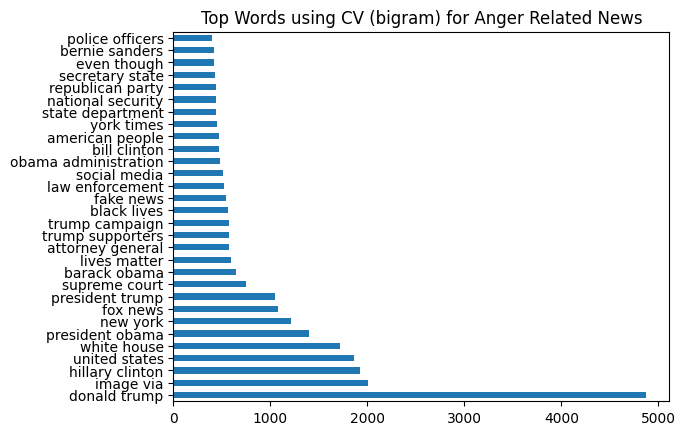

In [96]:
# plot top occuring words in a horizontal bar chart
X_anger_bi_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words using CV (bigram) for Anger Related News', fontsize=12);

In [97]:
X_anger = anger_df['text']
X_anger_cvec_tri = cvec_trigram.fit_transform(X_anger)

In [98]:
X_anger_df = pd.DataFrame(X_anger_cvec_tri.toarray(), columns=cvec_trigram.get_feature_names())

C:\Users\alvintky89\.conda\envs\dsi-sg-capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


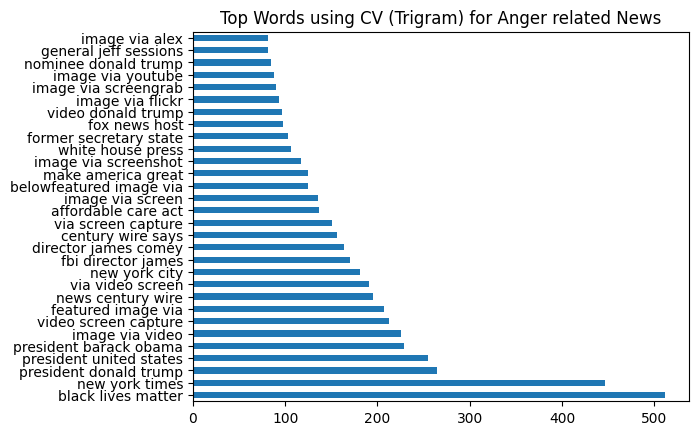

In [99]:
# plot top occuring words in a horizontal bar chart
X_anger_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words using CV (Trigram) for Anger related News', fontsize=12);

## Conclusion and Recommendations

### Conclusion

This study provides a baseline for the future tests and broadens scope of the solutions dealing with fake news detection

In this project, we applied multiple models for fake news classification and the result of the modeling is presented below:

|Model|Transformer|Train Score (Accuracy)|Test Score (Accuracy)|Recall|
|:---------:|:--------------:|:----------:|:----------:|:----------:|
|  Multinomial Naive Bayes (Baseline)  |      Count Vectorizer     |   0.9505  | 0.9543  | -  |
|   Multinomial Naive Bayes (Hyperparameter Tuning) |      TF-IDF Vectorizer     |   0.9344  |   0.9359 | - |
|   Light Gradient Boosting Machine   |      Count  Vectorizer    |  0.9903  |   0.9931  |0.9935
|  Logistics Regression  |     Count Vectorizer   |   0.9847  |   0.9873  | 0.9889  |
|  SVM Linear Kernel |     Count Vectorizer   |   0.9838  |   0.9836  | 0.9851  |
|   LSTM (2 x LSTM layer, 1 word embedding layer: best accuracy)  |     GloVe Embedding    |   0.9960 |   0.9950  | - |

The best model is **Light Gradient Boosting Machine** model. However, for the purpose of deployment, the **Logistic Regression** model which have an accuracy score of 0.985 (train score) and 0.987 (test score) respectively is selected instead as its result is comparable to the best model (LGBM) are is more explanable.

- Sentiment analysis showed that fake news portrays a negative sentiment (e.g. anger and fear)

### Challenge of Developing a Fake News Classifier

- Continuous training of fake news classication model is required for the fake news classifier to maintain it's efficacy. The fake news classifier model may be effective only in the context of near-term and may have limited effectiveness when it comes to predicting news with words (n-grams) and / or context this model is not trained on. One example would be for the case of Covid vaccination related news, since our fake news classifier which is trained using political news articles published from 2016 to 2018 would not have captured any n-grams/ context related to Covid vaccination, it is unlikely that the model can accurately classify  fake news in related to Covid-19 vaccination.

- Challenges faced in collection of extensive fake news article for modeling and training. Unilike real news which are readily available from real world sources, fake news which are accurately labeled are not readily available. Models which are not trained with sufficient fake news dataset will not be able to predict accurately the occurrence of fake news. 

- The quality of the fake news used in the training dataset may impact how the model's accuracy performace. This is evident from the test using GPT-2 generated data whereby there is a significant drop in performance of the model. The GPT-2 generated text may potentially have a writting style which more closely resembled that of the mainstream media published news article. As such. our model trained on human generated fake news text (9more commonly extracted from twitter, 21century posts_ may not perform well on such news article with a different writting style (affect choice of words).

### Recommendation (Future Works)
* Since social media is the key source of fake news, model training should not be limited to real news article from the mainstream newspaper (e.g. Reuters, BBC, The Straits Times), our model should be trained with news article (both real and fake) posted on social media platforms (e.g. twitter, facebook and etc).

* Other than social media, fake news generated by Artificial Intelligence are also emerging threats. As such, model should also be trained on fake news dataset generated by AI. 

* Given the right labelled dataset, this can be further expanded into a multi-classification problem. A piece of fake news may have carying level of factual correctness ranging from total untruth to deceptive news to manipulated news with some truth.A multi-classification would minimize problem of text which are partially false and contain misleading information being classified as true.

- Contextual learning is essential. Deep learning neural network should be augmented With a large dataset. Deep learning methods (e.g. LSTM with word embedding using GloVe) may be the better option for fakew news prediction model on unseen data. Our LSTM model developed as part of this project may not have picked up the context or the word sequence for accurate prediction.
